In [17]:
import pandas as pd
import numpy as np

from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = (18.0, 10.0)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm

In [2]:
ds = pd.read_csv('../data/processed/train_3600000000000.csv', parse_dates=[1])


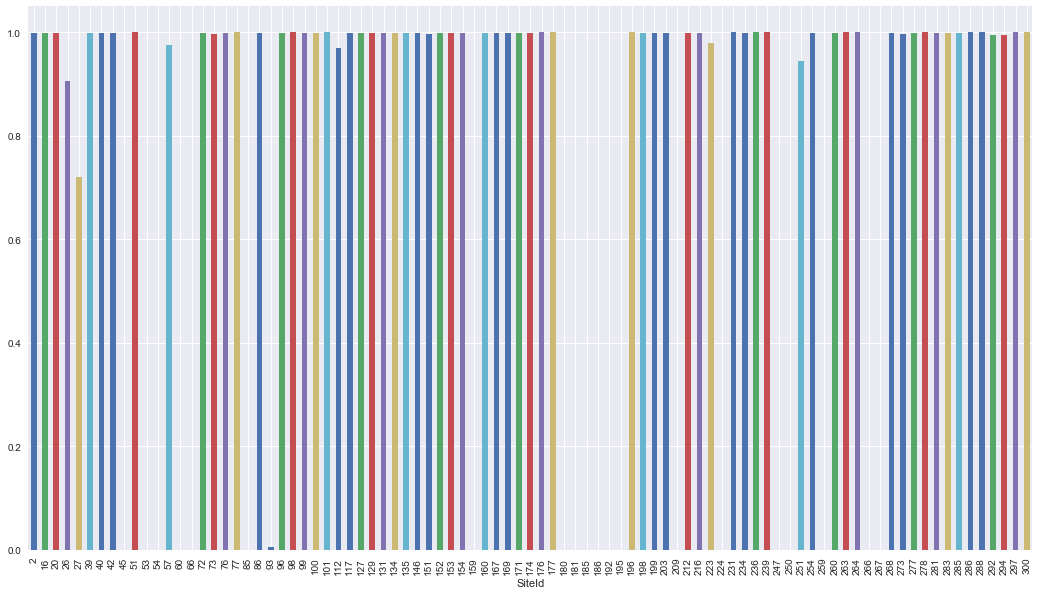

In [5]:
(ds.groupby('SiteId')['HasTemperature'].sum()/ds.groupby('SiteId')['HasTemperature'].count()).plot(kind='bar')

In [3]:
ds['SiteId'].value_counts()

dataset = ds
dataset.head()

,ForecastId,Timestamp,obs_id,SiteId,Value,Frequency,DayOfMonth,DayOfWeek,DayOfYear,DaysInMonth,...,TemperatureMinDiff,TemperatureMaxDiff,TemperatureDailyMeanDiff,TemperatureWeeklyMeanDiff,TemperatureMonthlyMeanDiff,TemperatureQuarterlyMeanDiff,TemperatureYearlyMeanDiff,Consumption,ConsumptionPerSurfaceArea,ConsumptionPerTemperatureDiff
0,5,2013-01-01 01:00:00,4382312,2,30159.963708,3.600000e+12,1,1,1,31,...,-18.0,-18.0,-18.0,-18.0,-18.0,-18.0,-18.0,30159.963708,4.945652,93.086308
1,5,2013-01-01 02:00:00,2016541,2,29793.536720,3.600000e+12,1,1,1,31,...,-18.0,-18.0,-18.0,-18.0,-18.0,-18.0,-18.0,29793.536720,4.885565,91.955360
2,5,2013-01-01 03:00:00,78869,2,31682.412161,3.600000e+12,1,1,1,31,...,-18.0,-18.0,-18.0,-18.0,-18.0,-18.0,-18.0,31682.412161,5.195304,97.785223
3,5,2013-01-01 04:00:00,1361014,2,29881.829185,3.600000e+12,1,1,1,31,...,-18.0,-18.0,-18.0,-18.0,-18.0,-18.0,-18.0,29881.829185,4.900043,92.227868
4,5,2013-01-01 05:00:00,129169,2,30560.328940,3.600000e+12,1,1,1,31,...,-18.0,-18.0,-18.0,-18.0,-18.0,-18.0,-18.0,30560.328940,5.011304,94.322003


In [4]:
dataset['ConsumptionShift'] = dataset.groupby('ForecastId')['Consumption'].shift(192).values
dataset['ConsumptionTrend'] = dataset.groupby('ForecastId')['ConsumptionShift'].rolling(7*2, min_periods=7).mean().values
dataset['ConsumptionTrend'] = dataset.groupby('ForecastId')['ConsumptionTrend'].transform(lambda x: x.fillna(x[x.first_valid_index()])).values

In [5]:
features = [
    'IsMonthEnd', 'IsQuarterEnd', 'IsQuarterStart', 'IsYearEnd', 'IsYearStart', 'DayOfMonth_cos', 
    'DayOfMonth_sin', 'Quarter_cos', 'Quarter_sin', 'WeekOfYear_cos', 'WeekOfYear_sin', 'IsSpecialHoliday', 'IsWeekend',
    'IsHoliday', 'DistanceMean', 'DistanceVariance', 'NumStations', 'TemperatureMeanDiff', 'TemperatureVariance', 
    'TemperatureMinDiff', 'TemperatureMaxDiff', 'HasTemperature', 'ConsumptionTrend', 'Consumption', 'SiteId',
    'TemperatureDailyMeanDiff', 'TemperatureWeeklyMeanDiff', 'TemperatureMonthlyMeanDiff',
    'TemperatureQuarterlyMeanDiff', 'TemperatureYearlyMeanDiff', 'Hour_cos', 'Hour_sin',
]

ts = pd.get_dummies(dataset[features], columns=['SiteId'])
# ts = dataset[features]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a157f9048>,
      dtype=object)

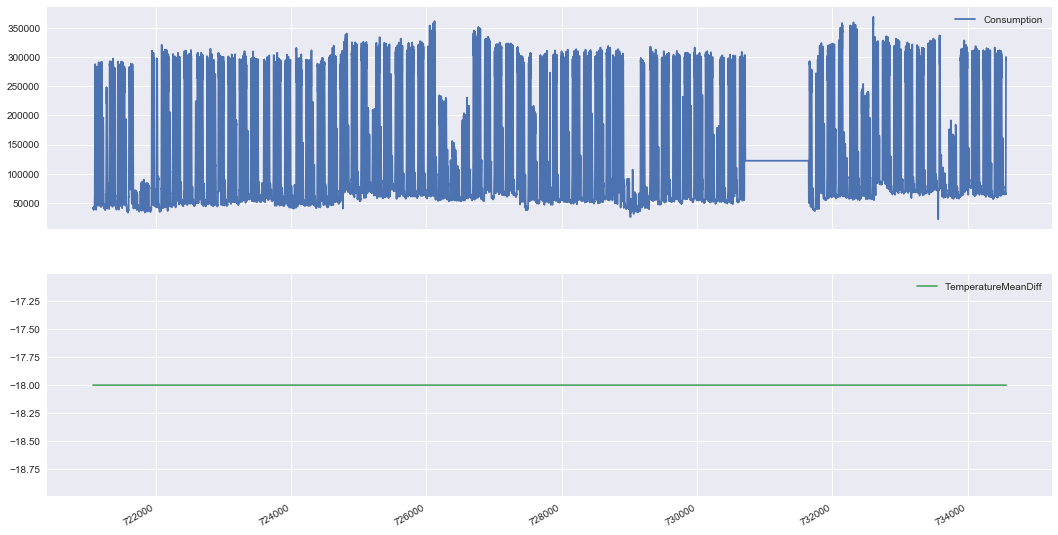

In [57]:
ts[['Consumption', 'TemperatureMeanDiff']].plot(subplots=True)

In [6]:
ts_x = ts.drop(columns=['Consumption'])
ts_y = ts['Consumption']
ts_fids = dataset['ForecastId']

ts_fids.value_counts()

6141    964
5409    964
4383    964
1309    964
5407    964
5404    964
1310    964
4381    964
5405    964
1311    964
4386    964
1312    964
5410    964
4387    964
1313    964
5411    964
4384    964
5408    964
1314    964
5406    964
1308    964
4382    964
5397    964
1299    964
1300    964
5398    964
1301    964
5399    964
5396    964
1302    964
       ... 
1716    964
1706    964
1717    964
1718    964
1719    964
1720    964
1721    964
1722    964
1723    964
1707    964
3736    964
4749    964
4753    964
3726    964
4754    964
3729    964
4755    964
3728    964
4752    964
3731    964
3730    964
3734    964
4758    964
3733    964
4759    964
3732    964
4756    964
3735    964
4757    964
6147    964
Name: ForecastId, Length: 1306, dtype: int64

In [7]:
import math

input_window_size = 75
output_window_size = 59
frequency = np.timedelta64(1, 'D')

In [8]:
def generate_test_train_split(x, y, forecast_ids, input_window_size, output_window_size, test_size=0.2):
    min_test_size = (output_window_size) * 2
    fids, counts = np.unique(forecast_ids, return_counts=True)
    
    num_forecasts_for_test = round(fids.shape[0]*test_size)
    testable_fids = fids[np.where(counts >= min_test_size)]
    
    test_fids = np.random.choice(testable_fids, num_forecasts_for_test)
    
    test_mask = np.repeat([False], forecast_ids.shape[0])
    
    test_size = output_window_size
    for fid in test_fids:
        indices,  = np.where(forecast_ids == fid)
        test_mask[indices[-test_size:]] = True
            
    train_mask = np.logical_not(test_mask)
    
    return x[train_mask], y[train_mask], forecast_ids[train_mask], x[test_mask], y[test_mask], forecast_ids[test_mask]
    
ts_xtrain, ts_ytrain, ts_ftrain, ts_xtest, ts_ytest, ts_ftest = generate_test_train_split(ts_x, ts_y, ts_fids, input_window_size, output_window_size)

print(ts_xtrain.shape, ts_ytrain.shape)
print(ts_xtest.shape, ts_ytest.shape)

(1244765, 119) (1244765,)
(14219, 119) (14219,)


In [9]:
from xgboost import XGBRegressor

regressor = XGBRegressor(max_depth=100, n_estimators=200, nthread=8)
regressor.fit(ts_xtrain, ts_ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=100, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=8, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [10]:
regressor1 = XGBRegressor(max_depth=100, n_estimators=200, nthread=8, silent=False)
regressor1.fit(ts_x, ts_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=100, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=8, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [23]:
import pickle

pickle.dump(regressor1, open("model_freq_1h_xgb.pkl", 'wb'), protocol=4)

OSError: [Errno 22] Invalid argument

In [22]:
from lightgbm import LGBMRegressor

regressor = LGBMRegressor(num_leaves=1000, n_estimators=2000)
regressor.fit(ts_xtrain, ts_ytrain)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=2000,
       n_jobs=-1, num_leaves=1000, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [15]:
y_pred = regressor.predict(ts_xtest)

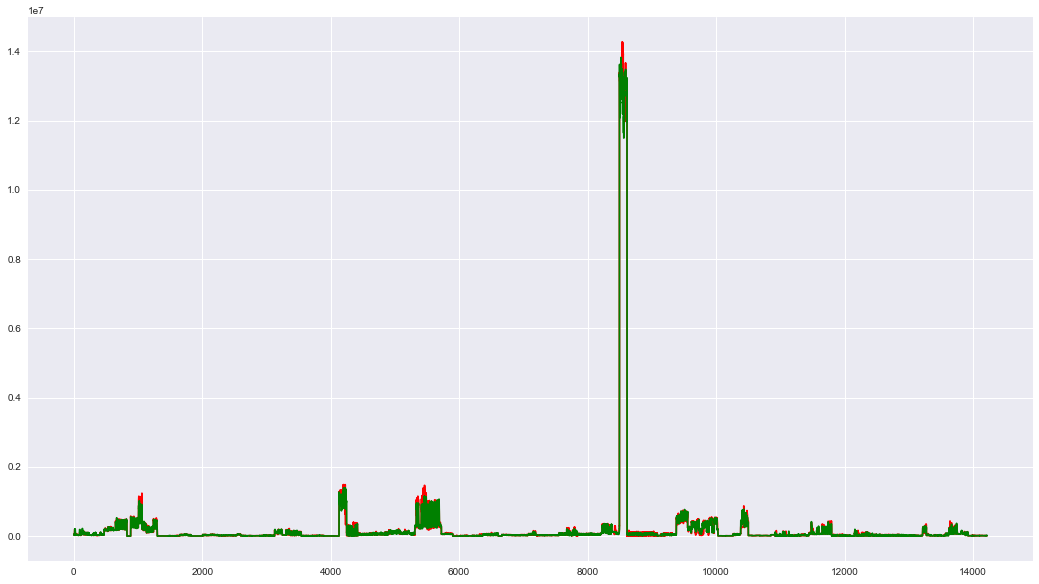

In [18]:
plt.plot(range(ts_ytest.shape[0]), ts_ytest, color='red')
plt.plot(range(ts_ytest.shape[0]), y_pred, color='green')

In [19]:
def _nwrmse(y_truth, y_pred, forecast_ids):
    errors = []

    fids = np.unique(forecast_ids)
    
    for fid in fids:
        forecast_y_pred = y_pred[forecast_ids == fid]
        forecast_y_truth = y_truth[forecast_ids == fid]
        
        count = 200
        weights = (3 * count - 2 * np.arange(1, count + 1) + 1) / (2 * count ** 2)
        weights = weights[:forecast_y_pred.shape[0]]
        
        error = np.sqrt(np.sum(((forecast_y_truth - forecast_y_pred) ** 2) * weights))
        mean_error = error / np.average(forecast_y_truth)
        errors.append(mean_error)

    return np.average(errors)

_nwrmse(ts_ytest, y_pred, ts_ftest)

0.2603250812273587